Generative Adversarial Networks

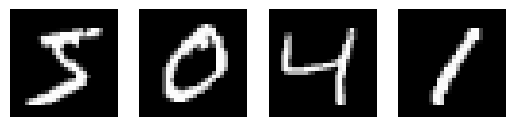

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU # relu versiyonudur. girdi +x ise +x verir, -x ise -ax iler çarpımını verir, a = çok kücük bir degerdir
from tensorflow.keras.optimizers import Adam
# %pip install tqdm
from tqdm import tqdm # for dongusune ilerleme sayaci ekler

import warnings
warnings.filterwarnings("ignore")

# veri setini yükle
(x_train, _), (_, _) = mnist.load_data()

#normalizasyon
x_train = x_train.astype('float32') / 255.0

#boyutların ayarlanması(28x28) -> (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)


plt.figure()
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

8.3

In [ ]:
# gan param
z_dim = 100 # gurultu vektorunun boyutu

# discriminator modeline tanımla
def build_disc():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides = 2 , padding='same', input_shape = ( 28,28,1 )))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=3, strides = 2 , padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0002, 0.5), metrics = ['accuracy']) # 0.0002 = learning rate, 0.5 = beta_1

    return model

# generator modeline tanımla
def build_gen():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim = z_dim)) # gurultu vektorlerinden yuksek boyutlu uzaya donusum
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7,7,128)))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(64, kernel_size=3, strides = 2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1, kernel_size=3, strides = 2, padding='same',activation='tanh'))

    return model

print(build_disc())
print(build_gen())


<Sequential name=sequential_24, built=True>
<Sequential name=sequential_25, built=True>


8.4

In [ ]:
def build_gan(gen, disc):
    disc.trainable = False # discriminator modeli eğitilmez

    model = Sequential()
    model.add(gen) # generator modeli
    model.add(disc) # discriminator modeli
    model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0002, 0.5))
    return model

disc = build_disc()
gen = build_gen()
gan = build_gan(gen, disc)
print(gan.summary())

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_27 (Sequential)      │ (None, 28, 28, 1)      │       708,609 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_26 (Sequential)      │ (None, 1)              │        80,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,378 (3.01 MB)

 Trainable params: 708,225 (2.70 MB)

 Non-trainable params: 81,153 (317.00 KB)

None


8.5.6

In [ ]:
epochs = 10000

batch_size = 64
half_batch = batch_size // 2

for epoch in tqdm(range(epochs), desc="Traiding Process"):

    idx = np.random.randint(0, x_train.shape[0], half_batch)
    real_imgs = x_train[idx]
    real_labels = np.ones((half_batch, 1)) # gerçek resimler için etiketler

    noise = np.random.normal(0, 1, (half_batch, z_dim))
    fake_imgs = gen.predict(noise, verbose=0)
    fake_labels = np.zeros((half_batch, 1)) # sahte resimler için etiketler

    d_loss_real = disc.train_on_batch(real_imgs, real_labels)
    d_loss_fake = disc.train_on_batch(fake_imgs, fake_labels)
    d_loss = np.add(d_loss_real, d_loss_fake) * 0.5

    noise = np.random.normal(0, 1, (batch_size, z_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} [D loss: {d_loss[0]} - D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")

Trading Process:   0%|          | 2/10000 [00:01<2:06:52,  1.31it/s]

Epoch: 0 [D loss: 0.6952242851257324 - D accuracy: 47.65625] [G loss: 0.6999276876449585]


Trading Process:  10%|█         | 1002/10000 [01:54<17:58,  8.35it/s]

Epoch: 1000 [D loss: 1.1583688259124756 - D accuracy: 19.76642608642578] [G loss: 0.20813821256160736]


Trading Process:  20%|██        | 2002/10000 [03:46<14:53,  8.95it/s]

Epoch: 2000 [D loss: 1.2560322284698486 - D accuracy: 19.627016067504883] [G loss: 0.17590704560279846]


Trading Process:  30%|███       | 3001/10000 [05:29<11:14, 10.38it/s]

Epoch: 3000 [D loss: 1.2920796871185303 - D accuracy: 19.561777114868164] [G loss: 0.1640937775373459]


Trading Process:  40%|████      | 4002/10000 [07:05<09:42, 10.30it/s]

Epoch: 4000 [D loss: 1.3112051486968994 - D accuracy: 19.501420974731445] [G loss: 0.1578574925661087]


Trading Process:  50%|█████     | 5002/10000 [08:43<08:14, 10.10it/s]

Epoch: 5000 [D loss: 1.3231360912322998 - D accuracy: 19.514259338378906] [G loss: 0.15397752821445465]


Trading Process:  60%|██████    | 6002/10000 [10:23<07:28,  8.91it/s]

Epoch: 6000 [D loss: 1.3312599658966064 - D accuracy: 19.467357635498047] [G loss: 0.1513427197933197]


Trading Process:  70%|███████   | 7002/10000 [12:15<05:37,  8.89it/s]

Epoch: 7000 [D loss: 1.3371366262435913 - D accuracy: 19.493446350097656] [G loss: 0.14944007992744446]


Trading Process:  80%|████████  | 8002/10000 [14:06<03:41,  9.03it/s]

Epoch: 8000 [D loss: 1.3415520191192627 - D accuracy: 19.474931716918945] [G loss: 0.14800302684307098]


Trading Process:  90%|█████████ | 9002/10000 [15:56<01:50,  9.01it/s]

Epoch: 9000 [D loss: 1.3449839353561401 - D accuracy: 19.48049545288086] [G loss: 0.14688168466091156]


Trading Process: 100%|██████████| 10000/10000 [17:45<00:00,  9.38it/s]


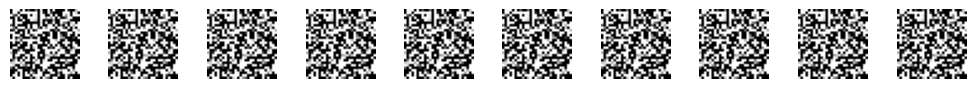

In [ ]:
def plot_gen(gen, epoch, examples=10, dim=(1, 10)):

    noise = np.random.normal(0, 1, size=[examples, z_dim])
    generated_imgs = gen.predict(noise,verbose=0)
    generated_imgs = 0.5*generated_imgs + 0.5

    plt.figure(figsize=(10, 1))
    for i in range(generated_imgs.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_imgs[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
    plt.show()
plot_gen(gen, epochs)